<a href="https://colab.research.google.com/github/matibag1714977/LabiagiProject/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Progetto-Scene Classification**

#Import vari

In [1]:
import numpy as np      #to perform mathematical operations on arrays and matrices
import matplotlib.pyplot as plt  #to visualize images and plot graphs

#provides algoithms and tools for data analysis and modeling(classification,regression,clustering)
from sklearn.model_selection import train_test_split        
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# It provides various tools and functions for image and video processing, including image filtering, feature detection, and object tracking.
import cv2
import imghdr
import os

import torch
import torchvision
import torchvision.transforms as transforms
import tensorflow as tf





#Import dataset Prova

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#folder_id = '1pFM_HpOjh0qbAadk0-1Fz89mwLHrnQHB?usp=share_link'
folder_id ='1uN5c1p7GkKE9xqQ3DyFbFWfRJQCTod-E?usp=share_link'
data_path = '/content/gdrive/MyDrive/Dataset/input_data2'


# mount the folder
drive.mount('/content/gdrive', force_remount=True)




Con SUN397

In [ ]:
dataset_dir = '/content/gdrive/MyDrive/Dataset/SUN397'
classess = os.listdir(dataset_dir)
print(len(classess))


#Dividere tramite Pytorch

100 ogni classe

In [ ]:
import os
import random
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# Definire la trasformazione delle immagini
transform = transforms.Compose(
    [transforms.Resize((224, 224)),transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Definire il percorso della cartella contenente le immagini selezionate
dataset_path = '/content/gdrive/MyDrive/Dataset/SUN397'

# Creare un dataset PyTorch dalla cartella delle immagini selezionate
dataset = ImageFolder(dataset_path, transform=transform)
classes276 = dataset.classes
# Creare un elenco di indici di campioni per ogni classe
class_indices = dataset.class_to_idx
indices = []
for c in class_indices.values():
    class_samples = [i for i, (_, label) in enumerate(dataset.samples) if label == c]
    indices += random.sample(class_samples, 100)

# Creare un Subset di PyTorch dataset contenente solo gli indici selezionati
subset = Subset(dataset, indices)
b_size=10

# Dividere il Subset in train, validation e test set utilizzando random_split
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
train_data = int(len(subset) * train_ratio)
val_data = int(len(subset) * val_ratio)
test_data = len(subset) - train_data - val_data
train_set, val_set, test_set = data.random_split(subset, [train_data, val_data, test_data])

train_loader=data.DataLoader(train_set,batch_size=b_size, shuffle=True, num_workers=2)
validation_loader=data.DataLoader(val_set,batch_size=b_size, shuffle=False,  num_workers=2)
test_loader=data.DataLoader(test_set,batch_size=b_size,shuffle=False, num_workers=2)


# Stampa delle dimensioni di ogni set
print(f"Numero di campioni di training: {len(train_set)}")
print(f"Numero di campioni di validation: {len(val_set)}")
print(f"Numero di campioni di test: {len(test_set)}")
print(classes276)

#100 ogni classe bilanciato 80 train, 10 test e 10 validation

In [ ]:
from sklearn.model_selection import train_test_split
import os
import random
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import Dataset


transform = transforms.Compose(
    [transforms.Resize((224, 224)),transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Definire il percorso della cartella contenente le immagini selezionate
dataset_path = '/content/gdrive/MyDrive/Dataset/SUN397'
#dataset_path = '/content/gdrive/MyDrive/Dataset/input_data'
# Creare un dataset PyTorch dalla cartella delle immagini selezionate
dataset = ImageFolder(dataset_path, transform=transform)
classes276 = dataset.classes

train_indices = []
valid_indices = []
test_indices = []

for c in classes276:
    class_samples = [i for i, (_, label) in enumerate(dataset.samples) if label == dataset.class_to_idx[c]]
    train_indices += class_samples[:80]
    valid_indices += class_samples[80:90]
    test_indices += class_samples[90:100]

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Creazione dei data loader per caricare i dati in batch
batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

# Stampa delle dimensioni di ogni set
print(f"Numero di campioni di training: {len(train_sampler)}")
print(f"Numero di campioni di validation: {len(valid_sampler)}")
print(f"Numero di campioni di test: {len(test_sampler)}")
print(classes276)





Numero immagini in train-set diviso per classi

In [ ]:
# Calcola il numero di immagini per classe nel train_sampler
class_counts = torch.zeros(len(classes276))
for idx in test_sampler.indices:
    _, label = dataset.samples[idx]
    class_counts[label] += 1
contatore=0
# Stampa il numero di immagini per classe
for i, c in enumerate(classes276):
    contatore+=1
    print(f"{contatore }\t{c}: {int(class_counts[i])}")


#Carico resnet50

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Load ResNet50 model
resnet50 = models.resnet50(pretrained=True)#weights=None




/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Prova uso gpu

In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Using GPU:", torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print("Using CPU")
print(device)

# Resnet che corre su device
resnet50.to(device)

Using GPU: Tesla T4
cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Loss e optimizer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

# Train

Inizializzo le liste per raccogliere dati

In [ ]:
loss_values = []  # lista vuota per raccogliere i valori della loss function
val_loss_values = []

# Carico dati

In [8]:
loss_values = np.load('/content/gdrive/MyDrive/Dataset/Test5/loss_SGD_.npy').tolist()
val_loss_values=np.load('/content/gdrive/MyDrive/Dataset/Test5/val_SGD_.npy').tolist()

#Definisco validation

In [ ]:
def validate(model, criterion, validation_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in validation_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(validation_loader)

# Training

In [ ]:
num_epochs=10
PATH = '/content/gdrive/MyDrive/Dataset/Test5/001.pth'

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data

        #mandare inputs e a ogni passo alla gpu
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # statistica
        running_loss += loss.item()
        if i % 200== 199: # ogni 200 batch da b_size immagini
            # aggiungi il valore della loss alla lista
            loss_values.append(running_loss / 200)
            val_loss = validate(resnet50, criterion, validation_loader)
            val_loss_values.append(val_loss)
            print(f'[{epoch + 1},{i + 1:4d}] loss: {running_loss / 200:.3f} val_loss:{val_loss:.3f}')
            running_loss = 0.0
            
           # torch.save(resnet50.state_dict(), PATH)   
print('Finished Training')

# Salvo dati

In [ ]:
np.save('/content/gdrive/MyDrive/Dataset/Test5/loss_SGD_.npy', loss_values)
np.save('/content/gdrive/MyDrive/Dataset/Test5/val_SGD_.npy', val_loss_values)

# Stampo loss function

In [ ]:
# creo grafico lineare
plt.plot(loss_values)
plt.plot(val_loss_values)

# titolo e assi
plt.title('Loss/Val Function')
plt.xlabel('200Batch')
plt.ylabel('Loss')

plt.legend(['loss','val_loss'],loc='upper right')
plt.show()

# Salvo il modello dopo il training

In [ ]:
PATH = '/content/gdrive/MyDrive/Dataset/Test5/001.pth'
torch.save(resnet50.state_dict(), PATH)

# Carico modello salvato precedentemente

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Using GPU:", torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print("Using CPU")
print(device)


#resnet50 = models.resnet50()
PATH = '/content/gdrive/MyDrive/Dataset/Test4/001.pth'
#PATH ='/content/gdrive/MyDrive/Dataset/SGD_lr001/resnet50lr001.pth'
# Carico i pesi salvati precedentemente
resnet50 = models.resnet50()
resnet50.load_state_dict(torch.load(PATH))
resnet50.eval()

resnet50.to(device)

# Uso modello su test

In [7]:

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
accuracy = 100 * correct / total
print('Accuracy of the model on the test images: {:.2f}%'.format(accuracy))

Accuracy of the model on the test images: 34.78%


#Classi peggiori e migliori

In [8]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes276}
total_pred = {classname: 0 for classname in classes276}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet50(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes276[label]] += 1
            total_pred[classes276[label]] += 1

cont=0
# print accuracy for each class in descending order of accuracy
for classname, correct_count in sorted(correct_pred.items(), key=lambda x: x[1], reverse=True):
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'{cont} {classname:5s} is {accuracy:.1f} %')
    cont+=1

# calculate overall accuracy
total_correct = sum(correct_pred.values())
total = sum(total_pred.values())
overall_accuracy = 100 * float(total_correct) / total
print(f'\nOverall accuracy is {overall_accuracy:.1f} %')


0 arrival_gate is 100.0 %
1 hot_spring is 90.0 %
2 marsh is 90.0 %
3 raceway is 90.0 %
4 sauna is 90.0 %
5 auditorium is 80.0 %
6 bamboo_forest is 80.0 %
7 barn  is 80.0 %
8 discotheque is 80.0 %
9 galley is 80.0 %
10 park  is 80.0 %
11 pharmacy is 80.0 %
12 promenade_deck is 80.0 %
13 skatepark is 80.0 %
14 ski_lodge is 80.0 %
15 wheat_field is 80.0 %
16 wind_farm is 80.0 %
17 aquarium is 70.0 %
18 ball_pit is 70.0 %
19 batters_box is 70.0 %
20 boxing_ring is 70.0 %
21 closet is 70.0 %
22 cockpit is 70.0 %
23 crosswalk is 70.0 %
24 electrical_substation is 70.0 %
25 gas_station is 70.0 %
26 hill  is 70.0 %
27 operating_room is 70.0 %
28 parking_lot is 70.0 %
29 racecourse is 70.0 %
30 riding_arena is 70.0 %
31 squash_court is 70.0 %
32 wave  is 70.0 %
33 amusement_arcade is 60.0 %
34 apartment_building is 60.0 %
35 bookstore is 60.0 %
36 catacomb is 60.0 %
37 cheese_factory is 60.0 %
38 conference_room is 60.0 %
39 courthouse is 60.0 %
40 ice_floe is 60.0 %
41 ice_shelf is 60.0 %
42 k

# Test con immagini

In [ ]:
import random
import torchvision
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.rcParams["figure.figsize"] = (20,20)

    plt.show()

b_size=5
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Spostare i dati sulla GPU
images = images.to(device)
labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join(f'{classes276[labels[j]]:5s}' for j in range(5)))

# Spostare la rete neurale sulla GPU
resnet50.to(device)

# Effettuare la previsione sulla GPU
outputs = resnet50(images)
_, predicted = torch.max(outputs.data, 1)

# Spostare le previsioni sulla CPU per la stampa
predicted = predicted.cpu()

print('Predicted: ', ' '.join(f'{classes276[predicted[j]]:5s}'
                              for j in range(5)))

# Test con classi selezionate

In [ ]:
import random
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.rcParams["figure.figsize"] = (20,20)
    plt.show()
b_size=8
# Definire le classi di interesse
classes_of_interest =[]
# Creare una lista contenente solo gli indici delle immagini che appartengono alle classi di interesse
indices_of_interest = [i for i, label in enumerate(test_loader.dataset.targets) if classes276[label] in classes_of_interest]

# Creare un nuovo SubsetRandomSampler per il dataset di test
test_sampler = torch.utils.data.SubsetRandomSampler(indices_of_interest)

# Creare un nuovo DataLoader utilizzando il SubsetRandomSampler creato per il dataset di test
test_loader_filtered = torch.utils.data.DataLoader(test_loader.dataset, batch_size=b_size, sampler=test_sampler, num_workers=2)

# Estrae un batch di immagini e relativi label dal dataloader filtrato
dataiter = iter(test_loader_filtered)
images, labels = next(dataiter)

# Spostare i dati sulla GPU
images = images.to(device)
labels = labels.to(device)

# Stampa le immagini
imshow(torchvision.utils.make_grid(images.cpu()))

# Stampa le etichette reali
print('GroundTruth: ', ' '.join(f'{classes276[labels[j]]:5s}' for j in range(len(labels))))

# Spostare la rete neurale sulla GPU
resnet50.to(device)

# Effettuare la previsione sulla GPU
outputs = resnet50(images)
_, predicted = torch.max(outputs.data, 1)

# Spostare le previsioni sulla CPU per la stampa
predicted = predicted.cpu()

# Filtrare le previsioni solo per le classi di interesse

predicted_of_interest = [classes276[predicted[j]] for j in range(len(predicted)) if classes276[predicted[j]] in set(classes_of_interest)]

# Stampa le etichette previste


print('Predicted: ', ' '.join(f'{classes276[predicted[j]]:5s}' for j in range(len(predicted))))

Contatore di immagini per classe

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms


# Definizione delle classi di interesse
class_names = classes276

# Selezione degli indici dei campioni di test per le classi di interesse
test_indices = []
for c in class_names:
    class_samples = [i for i, (_, label) in enumerate(dataset.samples) if dataset.classes[label] == c]
    test_indices += class_samples[90:100]

# Creazione del test loader
batch_size = 10
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

# Calcola il numero di campioni per ogni classe nel test loader
class_counts = {c: 0 for c in class_names}
for index in test_indices:
    _, label = dataset.samples[index]
    class_name = dataset.classes[label]
    if class_name in class_names:
        class_counts[class_name] += 1

# Stampa il numero di campioni per ogni classe nel test loader
for c in class_names:
    print(f"{c}: {class_counts[c]}")



Test con le classi selezionate

In [ ]:
import random
import torchvision
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.rcParams["figure.figsize"] = (20,20)

    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)

# Spostare i dati sulla GPU
images = images.to(device)
labels = labels.to(device)

print('GroundTruth: ', ' '.join(f'{classes276[labels[j]]:5s}' for j in range(10)))

# Spostare la rete neurale sulla GPU
resnet50.to(device)
imshow(torchvision.utils.make_grid(images.cpu()))
# Effettuare la previsione sulla GPU
outputs = resnet50(images)
_, predicted = torch.max(outputs.data, 1)

# Spostare le previsioni sulla CPU per la stampa
predicted = predicted.cpu()

print('Predicted: ', ' '.join(f'{classes276[predicted[j]]:5s}'
                              for j in range(10)))

# Previsione su tutto il test_loader di classi di mia scelta

In [197]:
from sklearn.metrics import confusion_matrix

resnet50.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)

        true_labels += labels.cpu().numpy().tolist()
        predicted_labels += predicted.cpu().numpy().tolist()
print(true_labels)
print(predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(conf_matrix)



[84, 48, 230, 131, 79, 40, 56, 141, 52, 40, 130, 69, 202, 193, 130, 117, 85, 0, 225, 271, 114, 79, 230, 83, 22, 8, 22, 119, 183, 87, 40, 115, 273, 222, 212, 128, 165, 131, 1, 256, 239, 182, 25, 44, 24, 48, 272, 169, 257, 96, 181, 16, 258, 160, 135, 215, 248, 117, 151, 110, 220, 137, 270, 219, 126, 37, 182, 6, 26, 250, 273, 0, 76, 116, 129, 195, 232, 271, 270, 74, 244, 140, 99, 195, 247, 86, 28, 39, 168, 231, 24, 204, 60, 1, 227, 217, 54, 2, 219, 60, 107, 241, 243, 179, 196, 107, 56, 179, 185, 32, 249, 241, 172, 41, 231, 162, 199, 157, 121, 59, 82, 60, 264, 30, 188, 121, 237, 271, 40, 14, 3, 153, 36, 211, 272, 55, 251, 238, 267, 218, 131, 235, 213, 124, 81, 142, 205, 153, 8, 191, 159, 45, 85, 179, 273, 153, 194, 120, 75, 205, 250, 170, 116, 14, 259, 189, 153, 59, 78, 256, 141, 112, 119, 176, 229, 207, 199, 266, 72, 133, 100, 232, 15, 58, 263, 170, 275, 215, 83, 247, 11, 221, 246, 216, 254, 257, 108, 51, 114, 181, 91, 37, 252, 227, 193, 45, 223, 43, 150, 110, 238, 113, 6, 33, 188, 97, 88

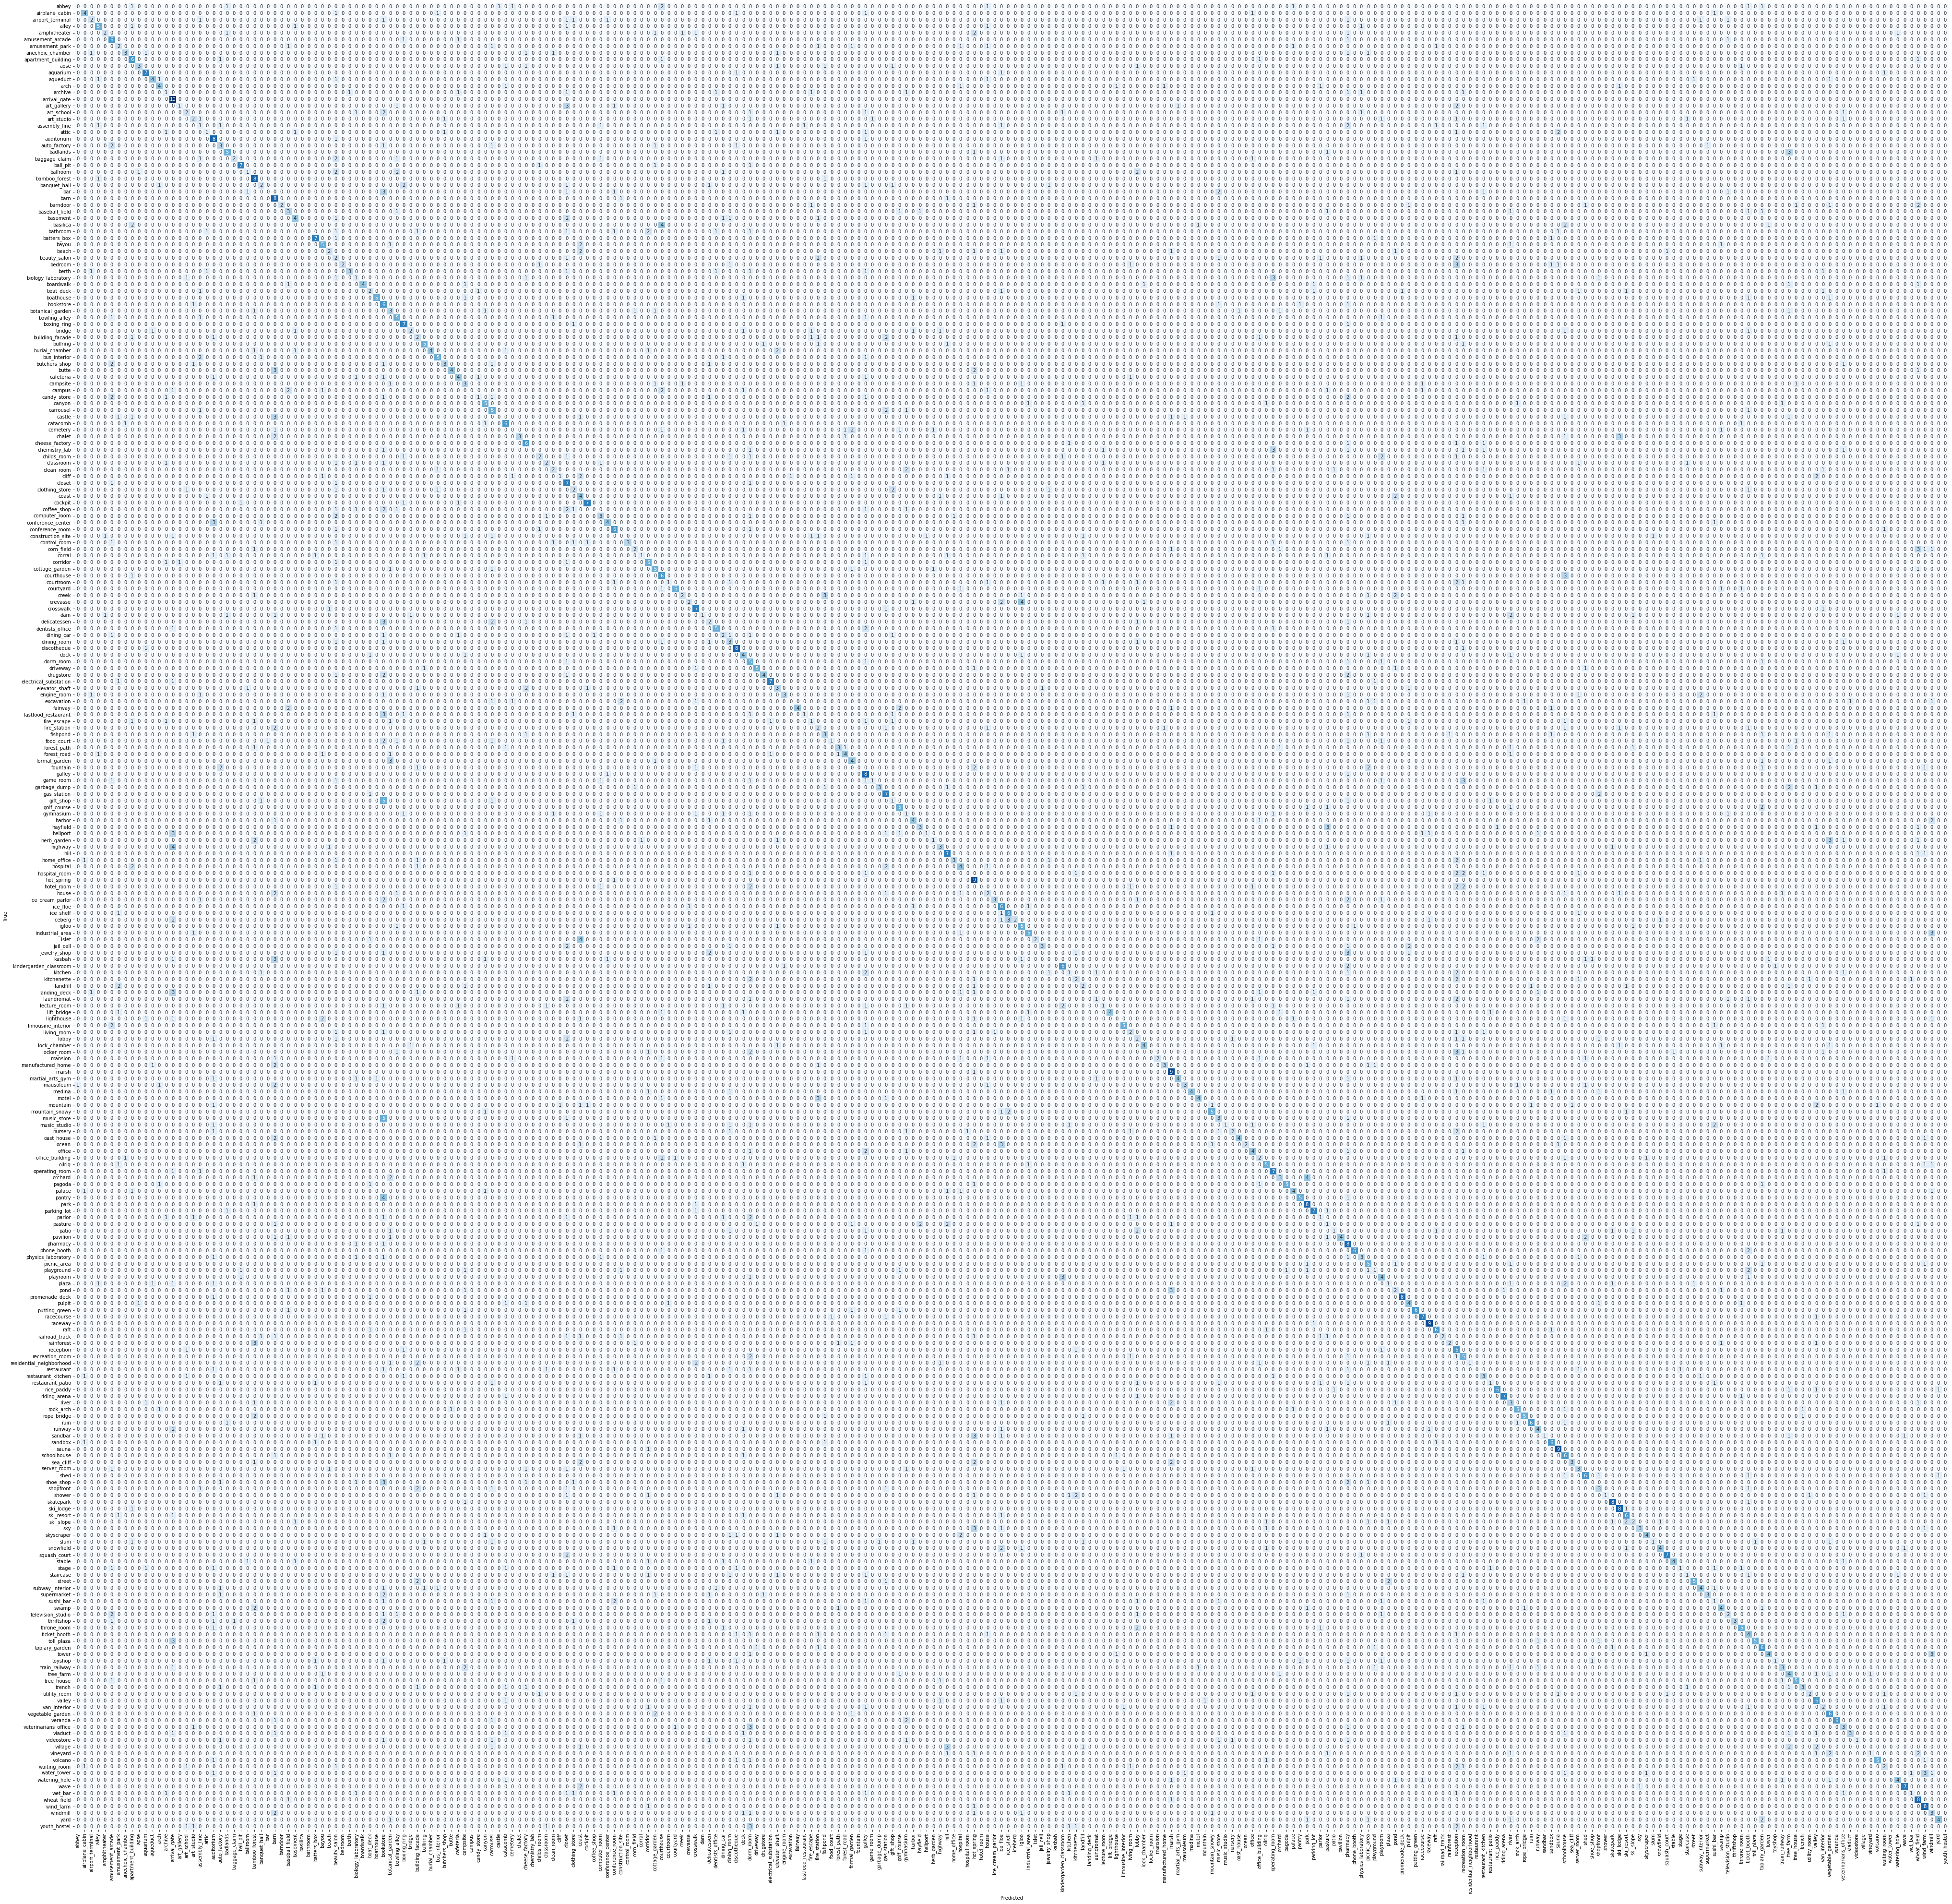

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creare la confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)



# Creare la visualizzazione utilizzando seaborn
fig, ax = plt.subplots(figsize=(70, 70))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_names, yticklabels=class_names, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')

plt.savefig('/content/gdrive/MyDrive/Dataset/Test5/conf_matrix.png')
plt.show()

